### Cross Entropy Benchmarking

In [114]:
"""
Cross entropy benchmarking of two qubits (XEB) is a method for characterizing the fidelity of a two-qubit gate.
The XEB sequence consists of a random sequence of single-qubit gates and a two-qubit gate, followed by a measurement.
The sequence is repeated many times, and the results are used to calculate the cross entropy between the ideal and measured states.
The cross entropy is a measure of the distance between two probability distributions, and is related to the fidelity of the two-qubit gate.
The cross entropy is calculated as follows:
    1. The ideal state is calculated by applying the sequence of single-qubit gates and the two-qubit gate to the initial state |00>.
    2. The measured state is calculated by applying the sequence of single-qubit gates to the initial state |00>, followed by a measurement.
    3. The cross entropy is calculated between the ideal and measured states.
The cross entropy is calculated for a range of sequence depths, and the results are used to calculate the fidelity of the two-qubit gate.
In this script, we provide an example of how to run an XEB sequence on the OPX.

Author: Arthur Strauss - Quantum Machines
Created: 16/01/2024 (Last modified: 16/01/2024)
"""
import numpy as np
import pandas as pd
import seaborn as sns
from qm import QuantumMachinesManager
from qm.qua import *
from qm.simulate.credentials import create_credentials
from scipy.optimize import curve_fit

import sys
sys.path.append('/Users/adamachuck/Documents/GitHub/PYQUM/TEST/BETAsite/QM/OPXPlus/Configurations')

from configuration import *
from qm.simulate import SimulationConfig
from matplotlib import pyplot as plt
import pprint
from macros import multiplexed_readout, qua_declaration, cz_gate
from qiskit import QuantumCircuit
from qiskit.circuit.library import CZGate, RXGate, RYGate, RZGate, HGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate
from qiskit.quantum_info import Statevector
from time import sleep
from scipy.linalg import sqrtm
import warnings

import os, fnmatch

%matplotlib inline


### Setting parameters:

In [142]:
qubits = [4, 5] # |00> = |q5,q4> |q4=0> = 10 + 00
apply_cz = True
seqs = 42  # 101 # Number of random sequences to run per depth
max_depth = 20  # 7  # Max depth of the XEB sequence
step = 2  # Step for the depth iteration
avgs = 57  # 101  # Number of averages per sequence
depths = np.arange(1, max_depth+1, step)  # Create an array of depths to iterate through
gate_set_choice = 2  # Choose the gate-set: 1, 2, 3 or 4
impose_0_cycle = True
time_per_point = 16/(420*20*37) # in min
print(f"Estimated runtime: {seqs*avgs*len(depths)*time_per_point} minutes")

save_notebook_dir = save_dir.parents[6]/"data"
comment = f"s({seqs})_d({max_depth})_g({gate_set_choice})_cz({int(apply_cz)})_0cyc({int(impose_0_cycle)})"
filename = f"XEB_q{'_'.join([str(x) for x in qubits])}_{comment}"


Estimated runtime: 1.2324324324324325 minutes


### Selecting & Loading data:

In [197]:
flist = fnmatch.filter(os.listdir(save_notebook_dir), 'XEB*')
keyword = ""
flist = list(filter(lambda x: keyword in x, flist))
print("Saved data with keyword '%s':\n" %keyword)
for i, f in enumerate(flist): print("%s. %s" %(i,f))


Saved data with keyword '':

0. XEB_q4_5_s(42)_d(10)_g(2)_cz(1)_0cyc(1).npz
1. XEB_q4_5_s(420)_d(20)_g(2)_cz(1)_0cyc(1).npz
2. XEB_q4_5_s(420)_d(100)_g(2)_cz(1)_0cyc(1).npz
3. XEB_q4_5_s(420)_d(100)_g(2)_cz(0)_0cyc(1).npz
4. XEB_q4_5_s(42)_d(20)_g(2)_cz(1)_0cyc(1).npz
5. XEB_q4_5_s(420)_d(250)_g(2)_cz(0)_0cyc(1).npz
6. XEB_q4_5_s(42)_d(30)_g(2)_cz(0)_0cyc(1).npz
7. XEB_q5_s(420)_d(100)_g(2)_cz(0)_0cyc(1).npz
8. XEB_q4_s(420)_d(100)_g(2)_cz(0)_0cyc(1).npz


In [223]:
# Loading selected data:
filename = flist[7]
npz_file = np.load(save_notebook_dir/f"{filename}", allow_pickle=True)

# Create an empty dictionary to store variables
variables = {}

# Iterate through keys and store variables in the dictionary
for key in npz_file.files: variables[key] = npz_file[key]

# Close the npz file after loading the data
npz_file.close()

# loading variables from file:
g = variables['g']
a = variables['a']
quadratures = variables['quadratures']
state = variables['state']
# counts = variables['counts'][()]
counts = variables['counts'].item()
gate_set_choice = variables['gate_set_choice']
seqs = variables['seqs']
max_depth = variables['max_depth']
step = variables['step']
depths = np.arange(1, max_depth+1, step)
avgs = variables['avgs']
qubits = variables['qubits']
apply_cz = variables['apply_cz']
impose_0_cycle = variables['impose_0_cycle']

print("qubits = %s" %qubits)
print("step = %s" %step)
# print(counts['00'])


qubits = [5]
step = 5


### Derivations from set / loaded parameters

In [224]:
qubits = list(qubits)
qubits_el = [f"q{i}_xy" for i in qubits]
n_qubits = len(qubits)
dim = 2 ** n_qubits
multiplexed = qubits + [x+1 for x in range(5) if (x+1) not in qubits]
print(f"multiplexed: {multiplexed}")

cz_type = "const_wf"
if n_qubits < 2:
    apply_cz = False
    print("CZ gate not applied (less than 2 qubits)")

multiplexed: [5, 1, 2, 3, 4]
CZ gate not applied (less than 2 qubits)


### Define Unitary & Amplitude Matrix

In [225]:
# Random gates
X90, Y90, Z180 = RXGate(np.pi / 2), RYGate(np.pi / 2), RZGate(np.pi)
Z45 = RZGate(1 * np.pi / 4)
T, X, Y, H = TGate(), XGate(), YGate(), HGate()
W = UnitaryGate((X.to_matrix() + Y.to_matrix())/np.sqrt(2), label='W')
# SW = UnitaryGate(sqrtm(W), label='SW')
SW = UnitaryGate(np.array([[1, -np.sqrt(1j)], [np.sqrt(-1j), 1]])/np.sqrt(2), label='SW') # from Supremacy paper

XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
# XY90 = UnitaryGate((T.to_matrix() @ X90.to_matrix()), label="XY90")
# XY90 = UnitaryGate((X90.to_matrix() @ T.to_matrix()), label="XY90")

XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
CZ, CP = CZGate(), CPhaseGate(np.pi/2)

X90_dict = {"gate": X90, 'amp_matrix': np.array([1., 0., 0., 1.])}
# Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., 1., -1., 0.])}
Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., -1., 1., 0.])} # verified w/ CX
# XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., 1., -1., 1.])}
XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])} # verified w/ CX

# TODO: For the dicts below, need to check the validity of amplitude matrices!
XY90mm_dict = {"gate": XY90mm, 'amp_matrix': 0.70710678 * np.array([-1., -1., 1., -1.])}
XY90pm_dict = {"gate": XY90pm, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])}
XY90mp_dict = {"gate": XY90mp, 'amp_matrix': 0.70710678 * np.array([-1., 1., -1., 1.])}
T_dict = {"gate": T, 'amp_matrix': np.array([1., 0., 0., 1])}  # No actual need for amp_matrix,
# but here for consistency with the current workflow
SW_dict = {"gate": SW, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])}  # Amp matrix similar to XY90 # verified w/ CX

# Possible gate sets
gate_dict1 = {0: X90_dict, 1: Y90_dict, 2: T_dict}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90_dict, 1: Y90_dict, 2: SW_dict}  # Supremacy gate set (https://www.nature.com/articles/s41586-019-1666-5)
gate_dict3 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict, 3: XY90mm_dict, 4: XY90pm_dict, 5: XY90mp_dict}  # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict}  # Currently used in the QM XEB example (XY90==XY90pp)
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]

# Gate set choice:
gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)
print("gate_dict: %s" %gate_dict)


gate_dict: {0: {'gate': Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), 'amp_matrix': array([1., 0., 0., 1.])}, 1: {'gate': Instruction(name='ry', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), 'amp_matrix': array([ 0., -1.,  1.,  0.])}, 2: {'gate': Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[ 0.70710678+0.j , -0.5       -0.5j],
       [ 0.5       -0.5j,  0.70710678+0.j ]])]), 'amp_matrix': array([ 0.70710678, -0.70710678,  0.70710678,  0.70710678])}}


In [ ]:
# Check Unitary:
from qiskit.quantum_info import Operator

Operator(XY90).is_unitary()
print("Check Identity: ")
print(XY90.to_matrix()@XY90.to_matrix().conjugate().transpose())


### Running QUA

In [145]:
qmm = QuantumMachinesManager(host=qop_ip, port=qop_port, cluster_name=cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(host="tyler-263ed49e.dev.quantum-machines.co", port=443, credentials=create_credentials())
# qubits = ["q0", "q1"]  # Fix which qubits to use on the chip (quantum elements in the configuration)
# readout_elements = ["rr0", "rr1"]  # Fix which readout resonators to use on the chip (readout elements in the
# configuration)
# ge_threshold = 0.1  # Threshold for the ground state population (used for the readout)
# thermalization_time = 100  # Thermalization time for the qubits (in ns)
simulate = False

def assign_amplitude_matrix(gate, a):
    """
    QUA Macro for assigning the amplitude matrix arguments for a given gate index.
    :param gate: Gate index
    :param a: Amplitude matrix arguments
    """
    with switch_(gate):
        for i in range(random_gates):
            with case_(i):
                for j in range(4):
                    assign(a[j], gate_dict[i]['amp_matrix'][j])


# QUA Program

with program() as xeb:
    # Declare QUA variables
    I, I_st, Q, Q_st, n, n_st = qua_declaration(nb_of_qubits=len(multiplexed))
    # I, Q = [declare(fixed) for _ in range(2)], [declare(fixed) for _ in range(2)]
    s, tot_state_ = declare(int), declare(int)
    d, d_ = declare(int), declare(int)
    g = [declare(int, size=max_depth) for _ in range(n_qubits)]  # Gate indices list for both qubits
    a = [[declare(fixed, size=max_depth) for _ in range(4)] for _ in
         range(n_qubits)]  # Amplitude matrices for both qubits (for all depths)
    counts = [declare(int, value=0) for _ in range(dim)] # Counts for the 4 possible states
    state = [declare(bool) for _ in range(len(multiplexed))] # State of the qubits
    # Declare streams
    # I_st, Q_st = [declare_stream() for _ in range(2)], [declare_stream() for _ in range(2)]
    s_st = declare_stream()
    counts_st = [declare_stream() for _ in range(dim)]
    state_st = [declare_stream() for _ in range(len(multiplexed))]
    g_st = [declare_stream() for _ in range(n_qubits)]

    # Randomize the random number generator
    r = Random()
    r.set_seed(12321)
    # r.set_seed(11111)

    # If we are simulating, we need to update the frequency of the qubits to 0 to visualize the sequence
    # if simulate:
    if True:
        a_st = [[declare_stream() for _ in range(4)] for _ in range(n_qubits)]
        # for qubit in qubits_el:
            # update_frequency(qubit, 0)

    # Generate and run the XEB sequences
    with for_(s, 0, s < seqs, s + 1):
        with for_each_(d, depths): # max-depths
            # Randomize the sequence of single-qubit gates
            # NOTE: different from Google: randomizing for each growing-depths and sequences
            with for_(d_, 0, d_ < d, d_ + 1):
                for q in range(n_qubits):
                    with if_(d_ == 0):
                        if impose_0_cycle: assign(g[q][d_], r.rand_int(random_gates-1)) # to ensure 0-cycle isn't repeated on the 1-cycle
                        else: assign(g[q][d_], r.rand_int(random_gates))
                    with if_(d_ > 0):
                        assign(g[q][d_], r.rand_int(random_gates))
                        with while_(g[q][d_] == g[q][d_ - 1]):  # Make sure the same gate is not applied twice in a row
                            assign(g[q][d_], r.rand_int(random_gates))
                    # Map the sequence indices into amplitude matrix arguments (each index corresponds to a random gate)
                    assign_amplitude_matrix(g[q][d_], [a[q][i][d_] for i in range(4)])
                    save(g[q][d_], g_st[q])

                    # if simulate:
                    if True:
                        for amp_matrix_element in range(4):
                            save(a[q][amp_matrix_element][d_], a_st[q][amp_matrix_element])

            # Run the XEB sequence
            with for_(n, 0, n < avgs, n + 1):
                # save(n, n_st)
                # Reset the qubits to their ground states (here simple wait but could be an active reset macro)
                if simulate:
                    wait(25, *qubits_el)
                else:
                    wait(3 * thermalization_time, *qubits_el)

                # NOTE: imposing first gate at 0-cycle:
                if impose_0_cycle:
                    for q in range(n_qubits): 
                        play("x90" * amp(*SW_dict["amp_matrix"]), qubits_el[q])
                        # play("y90", qubits_el[q])
                        # play("x180", qubits_el[q])

                # Play all cycles generated for sequence s of depth d
                with for_(d_, 0, d_ < d, d_ + 1):
                    for q in range(n_qubits):  # Play single qubit gates on both qubits
                        if T_dict in gate_dict.values():
                            with switch_(g[q][d_], unsafe=True):
                                for j in range(2):
                                    with case_(j):
                                        play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                                with case_(2):
                                    frame_rotation(np.pi/4, qubits_el[q])
                        elif SW_dict in gate_dict.values():
                            # raise NotImplementedError("SW gate not readily implemented yet")
                            # warnings.warn("SW gate not readily implemented yet")
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                        else:
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                    align()
                    if apply_cz:
                        # Insert your two-qubit gate macro here
                        cz_gate(qubits[0], qubits[1], cz_type)
                        frame_rotation_2pi(eval(f"cz{5}_{4}_2pi_dev"), "q5_xy")
                        frame_rotation_2pi(eval(f"cz{4}_{5}_2pi_dev"), "q4_xy")
                    align()

                # Measure the state (insert your readout macro here)
                multiplexed_readout(I, I_st, Q, Q_st, resonators=multiplexed, weights="rotated_")

                # State discrimination
                assign(state[0], I[0] > eval(f"ge_threshold_q{multiplexed[0]}"))
                assign(state[1], I[1] > eval(f"ge_threshold_q{multiplexed[1]}"))
                save(state[0], state_st[0])
                save(state[1], state_st[1])

                # State Estimation: returned as an integer, to be later converted to bitstrings
                for q in range(n_qubits):
                    assign(tot_state_, tot_state_ + 2**q * Cast.to_int(state[q]))

                # assign(tot_state_, Cast.to_int(state[0]) + 2 * Cast.to_int(state[1]))
                # assign(tot_state_, Cast.to_int(state[1]) + 2 * Cast.to_int(state[0]))
                with switch_(tot_state_):
                    for i in range(dim):  # Bitstring conversion
                        with case_(i):
                            assign(counts[i], counts[i] + 1)  # counts for 00, 01, 10 and 11
                assign(tot_state_, 0)
            for i in range(dim):  # Resetting Bitstring collection
                save(counts[i], counts_st[i])
                assign(counts[i], 0)

            # Save the sequence iteration to get the progress bar
            save(s, s_st)

    # Save the results
    with stream_processing():
        s_st.save("s")
        for q in range(n_qubits):
            g_st[q].save_all(f"g{q}")
            I_st[q].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"I{q}")
            Q_st[q].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"Q{q}")
            state_st[q].boolean_to_int().buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(
                f"state{q}")
        for i in range(dim):
            string = "s" + bin(i)[2:].zfill(n_qubits)
            counts_st[i].buffer(len(depths)).save_all(string)

        # if simulate:
        if True:
            for q in range(n_qubits):
                for d_ in range(4):
                    a_st[q][d_].save_all(f"a{q + 1}_{bin(d_)[2:].zfill(2)}")

if simulate:
    job = qmm.simulate(config, xeb, SimulationConfig(15000))
    job.get_simulated_samples().con1.plot()
    job.get_simulated_samples().con2.plot()
    plt.show()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(xeb)

job.result_handles.wait_for_all_values()
result = job.result_handles
g = [result.get(f"g{i}").fetch_all()['value'] for i in range(n_qubits)]

if simulate:
    a = {f"a{q + 1}_{bin(i)[2:].zfill(2)}": result.get(f"a{q + 1}_{bin(i)[2:].zfill(2)}").fetch_all()['value'] for q in
         range(n_qubits) for i in range(4)}
else:
    a = {f"a{q + 1}_{bin(i)[2:].zfill(2)}": result.get(f"a{q + 1}_{bin(i)[2:].zfill(2)}").fetch_all()['value'] for q in
     range(n_qubits) for i in range(4)}
    quadratures = {f"I{i}": result.get(f"I{i}").fetch_all()['value'] for i in range(n_qubits)}
    quadratures.update({f"Q{i}": result.get(f"Q{i}").fetch_all()['value'] for i in range(n_qubits)})
    
    state = {f"state{i}": result.get(f"state{i}").fetch_all()['value'] for i in range(n_qubits)}
    counts = {bin(i)[2:].zfill(n_qubits): result.get(f"s{bin(i)[2:].zfill(n_qubits)}").fetch_all()['value'] for i in range(dim)}
    # state1, state2 = [result.get(f'state{i}').fetch_all()['value'] for i in [1, 2]]
    # state00, state01, state10, state11 = [result.get(f's{bin(i)[2:].zfill(2)}').fetch_all()['value'] for
    #                                       i in
    #                                       range(4)]
    # 
    # print(f"state1:\n {state1}, state2:\n {state2}")
    # print(f"state00:\n {state00}, state01:\n {state01}, state10:\n {state10}, state11:\n {state11}")


    # Close the quantum machines at the end in order to put all flux biases to 0 so that the fridge doesn't heat-up
    qm.close()

    

2024-02-25 16:54:48,934 - qm - INFO     - Performing health check
2024-02-25 16:54:48,952 - qm - INFO     - Health check passed
2024-02-25 16:54:50,286 - qm - INFO     - Sending program to QOP for compilation
2024-02-25 16:54:51,660 - qm - INFO     - Executing program


### Saving Data

In [146]:
# Data saving:
np.savez(save_notebook_dir/filename, g=g, a=a, quadratures=quadratures, state=state, counts=counts, 
            gate_set_choice=gate_set_choice, seqs=seqs, max_depth=max_depth, step=step, avgs=avgs, qubits=qubits,
            apply_cz=apply_cz, impose_0_cycle=impose_0_cycle)
print("Data saved as %s.npz" %filename)

Data saved as XEB_q4_5_s(42)_d(20)_g(2)_cz(1)_0cyc(1).npz


### Post-processing

In [226]:
# Rebuild gate sequences generated from the QUA:
print("n_qubits: %s" %n_qubits)

sq_indices = []
idx = 0
for s in range(seqs):
    sq_indices.append([])
    for i, d in enumerate(depths):
        sq_indices[s].append(np.zeros((n_qubits, d), dtype=int))
        for d_ in range(d):
            for q in range(n_qubits):
                sq_indices[s][i][q][d_] = g[q][idx]
            idx += 1


def cross_entropy(p, q, epsilon=1e-15):
    """
    Calculate cross entropy between two probability distributions.

    Parameters:
    - p: numpy array, the true probability distribution
    - q: numpy array, the predicted probability distribution
    - epsilon: small value to avoid taking the logarithm of zero

    Returns:
    - Cross entropy between p and q
    """
    q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

    # print(f"p: {p}, \nq: {q}")

    x_entropy = -np.sum(p * np.log(q))

    return x_entropy

records = []
incoherent_distribution = np.ones(dim) / (dim)
expected_probs = np.zeros((seqs, len(depths), dim))
measured_probs = np.zeros((seqs, len(depths), dim))
fidelities = np.zeros((seqs, len(depths)))


# Reconstruct every Circuit from the previously rebuilt gate sequences: (using Qiskit)
circuits_list = []
singularity = []
outlier = []
for s in range(seqs):
    circuits_list.append([])
    for d_, d in enumerate(depths):
        state = Statevector.from_int(0, dim)
        qc = QuantumCircuit(n_qubits)

        # NOTE: imposing first gate at 0-cycle:
        gate_cycle_0 = SW # XY90, H
        if impose_0_cycle:
            for i in range(n_qubits):
                qc.append(gate_cycle_0, [i]) 
                # qc.append(gate_cycle_0, [1])

        for k in range(d):
            sq_gates = [gate_dict[sq_indices[s][d_][q][k]]["gate"] for q in range(n_qubits)]
            for q in range(n_qubits):
                qc.append(sq_gates[q], [q])

            if apply_cz: 
                qc.append(CZ, [0, 1])

        circuits_list[s].append(qc)
        expected_probs[s, d_] = np.round(Statevector(qc).probabilities(), 5) # [1, 0]
        measured_probs[s, d_] = np.array([counts[bin(i)[2:].zfill(n_qubits)][s][d_] for i in range(dim)]) / avgs

        xe_incoherent = cross_entropy(incoherent_distribution, expected_probs[s, d_])
        xe_measured = cross_entropy(measured_probs[s, d_], expected_probs[s, d_])
        xe_expected = cross_entropy(expected_probs[s, d_], expected_probs[s, d_])

        f_xeb = ((xe_incoherent - xe_measured) / (xe_incoherent - xe_expected))
        if np.isinf(f_xeb) or np.isnan(f_xeb):
            print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
            singularity.append((s, d_))
            fidelities[s, d_] = np.nan  # Set all singularities to NaN
        elif f_xeb < 0 or f_xeb > 1:
            print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
            outlier.append((s, d_))
            fidelities[s, d_] = np.nan  # Set all outliers to NaN
        else:
            fidelities[s, d_] = f_xeb
            pass
            # print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            # print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")        
        
            records += [
            {
                "sequence": s,
                "depth": depths[d_],
                "pure_probs": expected_probs[s, d_],
                "sampled_probs": measured_probs[s, d_],
                "circuit": circuits_list[s][d_],
            }
        ]
        
print(f"singularities: {singularity}")
print(f"overall singularities: {len(singularity)/seqs/len(depths)*100}%")
print(f"outliers: {outlier}")
print(f"overall outliers: {len(outlier)/seqs/len(depths)*100}%")

for record in records:
    e_u = np.sum(record["pure_probs"] ** 2)
    u_u = np.sum(record["pure_probs"]) / dim
    m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
    record.update(e_u=e_u, u_u=u_u, m_u=m_u)


n_qubits: 1
seq 1, depth 46: f_xeb = -2.539643840348103
<<xe>>: xe_incoherent: 0.6937440424623658, xe_measured: 0.6967750727589099, xe_expected: 0.6925505560969198
seq 1, depth 51: f_xeb = -3.538365532459695
<<xe>>: xe_incoherent: 0.6946367028350142, xe_measured: 0.705172420848704, xe_expected: 0.6916591365216871
seq 1, depth 71: f_xeb = -0.830675172780407
<<xe>>: xe_incoherent: 0.695158465207207, xe_measured: 0.6984976752509624, xe_expected: 0.6911385905881324
seq 1, depth 76: f_xeb = -0.7398904539333556
<<xe>>: xe_incoherent: 0.7071151610464692, xe_measured: 0.7276890103317915, xe_expected: 0.6793085456536784
seq 2, depth 21: f_xeb = 2.66624006825576
<<xe>>: xe_incoherent: 0.6957734982436006, xe_measured: 0.6817809588321888, xe_expected: 0.6905254564119565
seq 2, depth 51: f_xeb = -0.5178234843305166
<<xe>>: xe_incoherent: 0.6937214374046565, xe_measured: 0.6943160509491746, xe_expected: 0.6925731435120247
seq 2, depth 61: f_xeb = 1.0796732410461873
<<xe>>: xe_incoherent: 0.715971459

### Inspecting Singularities

In [ ]:
# # Draw the circuit of your choice: first index is the sequence, second index is the depth index in depths array
for s, d_ in singularity:
    print(s, d_)
    print(circuits_list[s][d_])
# circuits_list[223][1].draw("mpl", style="clifford")

In [227]:
for s, d_ in singularity:
    print(expected_probs[s, d_])

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


### Check Gate Sequences history

In [ ]:
check_amp_matrix = 0
idx = 0
print("seqs: %s, depths: %s" %(seqs, depths))
for s in range(seqs):
    for id, d in enumerate(depths):
        print("circuit of seqs-%s, depths-%s:\n %s" %(s+1, d, circuits_list[s][id]))
        if check_amp_matrix:
            for d_ in range(d):
                print(f"cycle-{d_+1}")
                for q in range(n_qubits):
                    print(f'a{q+1}:\n')
                    print([a[f"a{q+1}_{bin(i)[2:].zfill(2)}"][idx] for i in range(4)])
                idx += 1

### Plotting Speckles from counts

<0> Measured
data: [[0.31578947 0.38596491 0.35087719 ... 0.52631579 0.50877193 0.77192982]
 [0.24561404 0.07017544 0.31578947 ... 0.61403509 0.63157895 0.61403509]
 [0.28070175 0.12280702 0.1754386  ... 0.42105263 0.33333333 0.64912281]
 ...
 [0.24561404 0.49122807 0.54385965 ... 0.59649123 0.31578947 0.57894737]
 [0.22807018 0.36842105 0.19298246 ... 0.54385965 0.35087719 0.40350877]
 [0.31578947 0.15789474 0.19298246 ... 0.61403509 0.54385965 0.70175439]]
241
<0> Expected
data: [[0.14645 0.28661 0.28661 ... 0.83931 0.60481 0.93403]
 [0.14645 0.03661 0.3125  ... 0.77044 0.98341 0.97155]
 [0.14645 0.03661 0.08931 ... 0.3726  0.08761 0.84882]
 ...
 [0.14645 0.5     0.55335 ... 0.67807 0.10634 0.67057]
 [0.14645 0.25    0.25    ... 0.34736 0.43031 0.37882]
 [0.14645 0.03661 0.14108 ... 0.97811 0.39435 0.94322]]
242
<1> Measured
data: [[0.68421053 0.61403509 0.64912281 ... 0.47368421 0.49122807 0.22807018]
 [0.75438596 0.92982456 0.68421053 ... 0.38596491 0.36842105 0.38596491]
 [0.71929

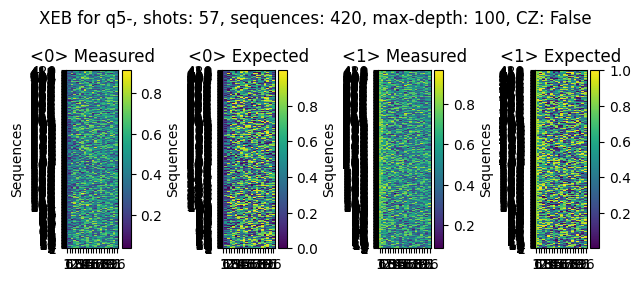

In [228]:
# Plot the results
def create_subplot(data, subplot_number, title):
    print(title)
    print("data: %s" % data)
    print(subplot_number)
    plt.subplot(subplot_number)
    # plt.pcolor(depths, range(seqs), np.abs(data), vmin=0., vmax=1.)
    plt.pcolor(depths, range(seqs), np.abs(data))
    ax = plt.gca()
    ax.set_title(title)
    if subplot_number > 244: ax.set_xlabel('Circuit depth')
    ax.set_ylabel('Sequences')
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, seqs + 1))
    plt.colorbar()


titles, data = [], []
for i in range(dim):
    titles.append(f"<{bin(i)[2:].zfill(n_qubits)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(n_qubits)}> Expected")
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]

k = 0
for title, d, n in zip(titles, data, plot_number):

    # if k%2 == 0:
    # plt.figure()
    # if k==0:
    qubits_involved = ""
    for q in qubits:
        qubits_involved += f"q{q}-"
    plt.suptitle(f"XEB for "+ qubits_involved+f", shots: {avgs}, sequences: {seqs}, max-depth: {max_depth}, CZ: {apply_cz}")
    create_subplot(d, n, title)
    plt.subplots_adjust(wspace=0.1, hspace=0.7)
    k+=1

    plt.tight_layout()
    plt.ion()


### Google fXEB estimation

In [229]:
import pandas as pd
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df


,sequence,depth,pure_probs,sampled_probs,circuit,e_u,u_u,m_u,y,x,numerator,denominator
0,0,1,"[0.14645, 0.85355]","[0.3157894736842105, 0.6842105263157895]","((Instruction(name='unitary', num_qubits=1, nu...",0.749995,0.5,0.630255,0.130255,0.249995,0.032563,0.062498
1,0,6,"[0.28661, 0.71339]","[0.38596491228070173, 0.6140350877192983]","((Instruction(name='unitary', num_qubits=1, nu...",0.591071,0.5,0.548668,0.048668,0.091071,0.004432,0.008294
2,0,11,"[0.28661, 0.71339]","[0.3508771929824561, 0.6491228070175439]","((Instruction(name='unitary', num_qubits=1, nu...",0.591071,0.5,0.563643,0.063643,0.091071,0.005796,0.008294
3,0,16,"[0.78504, 0.21496]","[0.7192982456140351, 0.2807017543859649]","((Instruction(name='unitary', num_qubits=1, nu...",0.662496,0.5,0.625018,0.125018,0.162496,0.020315,0.026405
4,0,21,"[0.23169, 0.76831]","[0.3333333333333333, 0.6666666666666666]","((Instruction(name='unitary', num_qubits=1, nu...",0.643981,0.5,0.589437,0.089437,0.143981,0.012877,0.020730
...,...,...,...,...,...,...,...,...,...,...,...,...
6566,419,71,"[0.84404, 0.15596]","[0.6140350877192983, 0.38596491228070173]","((Instruction(name='unitary', num_qubits=1, nu...",0.736727,0.5,0.578465,0.078465,0.236727,0.018575,0.056040
6567,419,76,"[0.24831, 0.75169]","[0.2982456140350877, 0.7017543859649122]","((Instruction(name='unitary', num_qubits=1, nu...",0.626696,0.5,0.601559,0.101559,0.126696,0.012867,0.016052
6568,419,81,"[0.89601, 0.10399]","[0.6491228070175439, 0.3508771929824561]","((Instruction(name='unitary', num_qubits=1, nu...",0.813648,0.5,0.618108,0.118108,0.313648,0.037044,0.098375
6569,419,86,"[0.97811, 0.02189]","[0.6140350877192983, 0.38596491228070173]","((Instruction(name='unitary', num_qubits=1, nu...",0.957178,0.5,0.609043,0.109043,0.457178,0.049852,0.209012


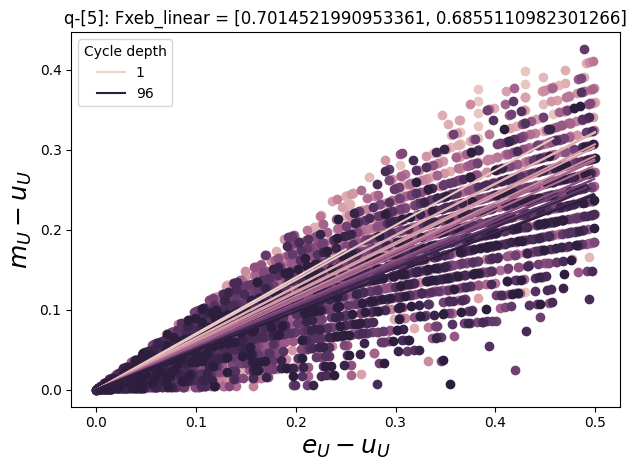

In [230]:
colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.title("q-%s: Fxeb_linear = %s" %(qubits, [fids["fidelity"][x] for x in [0, 1]]))
plt.tight_layout()


### Plotting fXEB curve

mask_log: 20
mask: 20
depths: [0.7014522  0.66590561 0.60388154 0.62183731 0.59013684 0.58742704
 0.56812032 0.5391597  0.54382579 0.55529866 0.5642335  0.53587508
 0.54064356 0.52018714 0.51431061 0.52956239 0.50614183 0.49416651
 0.49521928 0.48888882]


/var/folders/lz/657q9ypj0pd6l1g7f0wk81hm0000gn/T/ipykernel_40365/3616722213.py:48: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, _, _, _ = stats.linregress(masked_cycle_depths, log_fidelities)


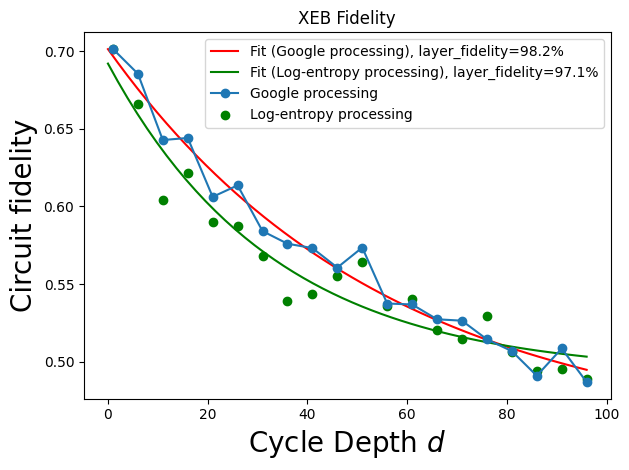

In [231]:
from scipy.stats import stats
from scipy import optimize

plot_log_XEB = 1

# Fit the data
def exponential_decay(cycle_depths: np.ndarray, a: float, layer_fid: float, b: float) -> np.ndarray:
    """An exponential decay for fitting.

    This computes `a * layer_fid**cycle_depths`

    Args:
        cycle_depths: The various depths at which fidelity was estimated. This is the independent
            variable in the exponential function.
        a: A scale parameter in the exponential function.
        layer_fid: The base of the exponent in the exponential function.
    """
    return a * layer_fid**cycle_depths + b

def _fit_exponential_decay(
    cycle_depths: np.ndarray, fidelities: np.ndarray
) -> Tuple[float, float, float, float]:
    """Fit an exponential model fidelity = a * layer_fid**x using nonlinear least squares.

    This uses `exponential_decay` as the function to fit with parameters `a` and `layer_fid`.

    Args:
        cycle_depths: The various depths at which fidelity was estimated. Each element is `x`
            in the fit expression.
        fidelities: The estimated fidelities for each cycle depth. Each element is `fidelity`
            in the fit expression.

    Returns:
        a: The first fit parameter that scales the exponential function, perhaps accounting for
            state prep and measurement (SPAM) error.
        layer_fid: The second fit parameters which serves as the base of the exponential.
        a_std: The standard deviation of the `a` parameter estimate.
        layer_fid_std: The standard deviation of the `layer_fid` parameter estimate.
    """
    cycle_depths = np.asarray(cycle_depths)
    fidelities = np.asarray(fidelities)
    mask = (fidelities > 0) & (fidelities < 1)
    masked_cycle_depths = cycle_depths[mask]
    masked_fidelities = fidelities[mask]
    
    log_fidelities = np.log(masked_fidelities)

    slope, intercept, _, _, _ = stats.linregress(masked_cycle_depths, log_fidelities)
    layer_fid_0 = np.clip(np.exp(slope), 0, 1)
    a_0 = np.clip(np.exp(intercept), 0, 1)
    b_0 = 1

    try:
        (a, layer_fid, b), pcov = optimize.curve_fit(
            exponential_decay,
            masked_cycle_depths,
            masked_fidelities,
            p0=(a_0, layer_fid_0, b_0),
            bounds=((0, 0, 0), (1, 1, 1)),
            nan_policy='omit'
        )
    except ValueError:  # pragma: no cover
        return 0, 0, np.inf, np.inf

    a_std, layer_fid_std, b_std = np.sqrt(np.diag(pcov))
    return a, layer_fid, a_std, layer_fid_std, b, b_std

fit_google = True
fit_log_entropy = True
xx = np.linspace(0, fids["depth"].max())
# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    a, layer_fid, a_std, layer_fid_std, b, b_std = _fit_exponential_decay(fids["depth"], fids["fidelity"])
    plt.plot(xx, exponential_decay(xx, a, layer_fid, b),
         label='Fit (Google processing), layer_fidelity={:.1f}%'.format(layer_fid*100),
         color='red')
except:
    raise
    print("Fit for Google processing data failed")
    fit_google = False
Fxeb = np.nanmean(fidelities, axis=0)
try:
    a2, layer_fid2, a_std2, layer_fid_std2, b2, b_std2 = _fit_exponential_decay(depths, Fxeb)
    if plot_log_XEB:
        plt.plot(xx, exponential_decay(xx, a2, layer_fid2, b2),
            label="Fit (Log-entropy processing), layer_fidelity={:.1f}%".format(layer_fid2*100),
            color="green")
    
except:
    raise
    print("Fit for Log-entropy processing data failed")
    fit_log_entropy = False

mask = (fids["fidelity"] > 0) & (fids["fidelity"] < 1)    
google_depths = fids["depth"][mask]
google_fids =  fids["fidelity"][mask]   
plt.plot(google_depths, google_fids, marker="o", label="Google processing")

mask_log = (Fxeb > 0) & (Fxeb < 1)

print("mask_log: %s" %len(mask_log))
print("mask: %s" %len(mask))
print("depths: %s" %Fxeb)

if plot_log_XEB:
    plt.scatter(depths[mask_log], Fxeb[mask_log], marker = 'o', color='green', label="Log-entropy processing")

plt.ylabel("Circuit fidelity", fontsize=20)
plt.xlabel("Cycle Depth $d$", fontsize=20)
plt.title("XEB Fidelity")
plt.legend(loc="best")
# plt.yscale("log")
plt.tight_layout()
plt.show()

In [ ]:
if fit_google:
    print("Google processing fit:")
    print("Params: ", a, layer_fid)
    print("layer-fidelity: ", layer_fid)
if fit_log_entropy:
    print("Log-entropy processing fit:")
    print("Params: ", a2, layer_fid2)
    print("layer-fidelity: ", layer_fid2)

In [ ]:
print(f"Currently used in the QM XEB example:\n {Fxeb}") # Derived from the fSim paper
print(f'Linear XEB of Google:\n {fids["fidelity"]}') # from Google's Supremacy paper

In [ ]:
print("relative difference", np.abs(fids["fidelity"] - Fxeb))

In [ ]:
plt.title("Relative difference between Google and derived XEB fidelities")
plt.plot(depths, (fids["fidelity"]-Fxeb)/Fxeb, 'o', label="XEB fidelity")
